<span style="color: lightblue"><font size="15">CHECKPOINT ANALYSIS</font></span>


In [1]:
%config InlineBackend.figure_format='retina'

In [1]:
import os
import torch
import pickle
import string
import tiktoken
from contextlib import nullcontext
from collections import OrderedDict

# <span style="color: purple"><font size="5">functions</font></span>


In [2]:
def model_info(out_dir, verbose=True):
    ckpt_path  = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location='cpu')

    ## get info from checkpoint
    state_dict = checkpoint['model']
    optimizer_state_dict = checkpoint['optimizer']
    modelargs = checkpoint['model_args']
    iter_num = checkpoint['iter_num']
    best_val_loss =round(checkpoint['best_val_loss'].item(), 5)
    config = checkpoint['config']

    ##print info
    if verbose:
        print('Best_val_loss was:', best_val_loss, 'saved at iteration', iter_num, '\n\n')
        print('Modelargs were: \n', modelargs, '\n\n')
        print('In more detail, configurations were: \n', config, '\n\n')
        
        print('Optimizer_state_dict contains:')
        for key, value in optimizer_state_dict.items():
            print(key)
    return checkpoint, state_dict, best_val_loss

In [3]:
def get_state_dict_info(state_dict):
    prefixes = ['_orig_mod.transformer.', '_orig_mod.']
    suffix = '.weight'
    
    # Create a new dictionary with modified keys
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key
        # Remove prefix if it exists
        for prefix in prefixes:
            if new_key.startswith(prefix):
                new_key = new_key[len(prefix):]
                break  # Only one prefix can match, so we can break after finding it
        # Remove suffix if it exists
        if new_key.endswith(suffix):
            new_key = new_key[:-len(suffix)]
        
        new_state_dict[new_key] = value
    
    # Update the original dictionary
    state_dict.clear()
    state_dict.update(new_state_dict)
    
    # Print the updated dictionary keys to verify
    for key, value in state_dict.items():
        print(key, '        ', list(value.size()))

    wte    = state_dict['wte']
    wpe    = state_dict['wpe']
    ln_f   = state_dict['ln_f']
    lm_head= state_dict['lm_head']



    return state_dict, wte,wpe, ln_f,lm_head 

In [4]:
# manually add mode parameter to model_args file for models i alredy ran 
def manually_add_modelarg (ckpt_path, arg, value):  #pass arg as str
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    model_args = checkpoint['model_args']
    print('Args were: \n', model_args, '\n\n')
    
    if arg not in checkpoint['model_args']:
        print(f'Adding {arg}  argument! \n')
        checkpoint['model_args'][arg] = value
        torch.save(checkpoint, ckpt_path)
        
        print('Args are now: \n', model_args, '\n\n')


# Results

In [6]:
out_dir = '../nanoGPT/OUT_GENOMIC_MODELS/out_Architecture_nr_2_Context_size_3_Model_I'
checkpoint,weights, best_val_loss = model_info(out_dir, verbose=True)

Best_val_loss was: 0.54121 saved at iteration 5000 


Modelargs were: 
 {'n_layer': 8, 'n_head': 8, 'n_embd': 384, 'block_size': 3, 'bias': False, 'vocab_size': 5, 'dropout': 0.2, 'genomic': True, 'mode': 'multi', 'predict_from': 'padding'} 


In more detail, configurations were: 
 {'out_dir': 'OUT_GENOMIC_MODELS/out_Architecture_nr_2_Context_size_3_Model_I', 'eval_interval': 250, 'log_interval': 10, 'eval_iters': 200, 'eval_only': False, 'always_save_checkpoint': False, 'init_from': 'scratch', 'wandb_log': False, 'wandb_project': 'genomic-char-3', 'wandb_run_name': 'genomic-gpt', 'genomic': True, 'dataset': 'genomic_char/architecture_nr_2_context_size_3', 'gradient_accumulation_steps': 1, 'batch_size': 64, 'block_size': 3, 'n_layer': 8, 'n_head': 8, 'n_embd': 384, 'dropout': 0.2, 'bias': False, 'learning_rate': 0.001, 'max_iters': 5000, 'weight_decay': 0.1, 'beta1': 0.9, 'beta2': 0.99, 'grad_clip': 1.0, 'decay_lr': True, 'warmup_iters': 100, 'lr_decay_iters': 5000, 'min_lr': 0.0001, '

In [7]:
weights, wte,wpe, ln_f,lm_head = get_state_dict_info(weights)

wte          [5, 384]
wpe          [3, 384]
h.0.ln_1          [384]
h.0.attn.c_attn          [1152, 384]
h.0.attn.c_proj          [384, 384]
h.0.ln_2          [384]
h.0.mlp.c_fc          [1536, 384]
h.0.mlp.c_proj          [384, 1536]
h.1.ln_1          [384]
h.1.attn.c_attn          [1152, 384]
h.1.attn.c_proj          [384, 384]
h.1.ln_2          [384]
h.1.mlp.c_fc          [1536, 384]
h.1.mlp.c_proj          [384, 1536]
h.2.ln_1          [384]
h.2.attn.c_attn          [1152, 384]
h.2.attn.c_proj          [384, 384]
h.2.ln_2          [384]
h.2.mlp.c_fc          [1536, 384]
h.2.mlp.c_proj          [384, 1536]
h.3.ln_1          [384]
h.3.attn.c_attn          [1152, 384]
h.3.attn.c_proj          [384, 384]
h.3.ln_2          [384]
h.3.mlp.c_fc          [1536, 384]
h.3.mlp.c_proj          [384, 1536]
h.4.ln_1          [384]
h.4.attn.c_attn          [1152, 384]
h.4.attn.c_proj          [384, 384]
h.4.ln_2          [384]
h.4.mlp.c_fc          [1536, 384]
h.4.mlp.c_proj          [384, 1536]
h

In [5]:
base_out_dir = '../nanoGPT/OUT_GENOMIC_MODELS/'

# Iterate through all subdirectories within the base directory
for subdir in os.listdir(base_out_dir):
    out_dir = os.path.join(base_out_dir, subdir)
    if os.path.isdir(out_dir) and not subdir.startswith('.') and os.path.exists(os.path.join(out_dir, 'ckpt.pt')):
        try:
            _, _, best_val_loss = model_info(out_dir, verbose=False)
            print(f'Model {subdir}:', best_val_loss)
        except FileNotFoundError as e:
            print(f"FileNotFoundError for model {subdir}: {e}")
        except Exception as e:
            print(f"An error occurred for model {subdir}: {e}")


Model out_Architecture_nr__Context_size_8_Model_Hyper_Tx: 1.322
Model out_Architecture_nr_2_Context_size_3_Model_G: 0.5654
Model out_Architecture_nr__Context_size_8_Model_Hyper_Ta: 1.35985
Model out_Architecture_nr__Context_size_8_Model_Hyper_Te: 1.33358
Model out_Architecture_nr__Context_size_8_Model_Hyper_Tu: 1.31804
Model out_Architecture_nr__Context_size_8_Model_Hyper_Td: 1.34057
Model out_Architecture_nr_0_Context_size_512_Model_QQa: 1.06651
Model out_Architecture_nr__Context_size_8_Model_Hyper_Tn: 1.33054
Model out_Architecture_nr__Context_size_8_Model_Hyper_Ty: 1.32305
Model out_Architecture_nr_1_Context_size_15_Model_M: 1.04431
Model out_Architecture_nr__Context_size_8_Model_Hyper_Tb: 1.34587
Model out_Architecture_nr_0_Context_size_5_Model_Pb: 1.37374
Model out_Architecture_nr__Context_size_8_Model_Hyper_Tt: 1.3235
Model out_Architecture_nr_0_Context_size_3_Model_Pa: 1.37112
Model out_Architecture_nr__Context_size_8_Model_Hyper_Tm: 1.33253
Model out_Architecture_nr__Context_si

In [25]:
ckpt_path  ='../nanoGPT/OUT_GENOMIC_MODELS/out_Architecture_nr_2_Context_size_3_Model_G/ckpt.pt'
manually_add_modelarg (ckpt_path, 'mode', 'multi')

Args were: 
 {'n_layer': 6, 'n_head': 6, 'n_embd': 384, 'block_size': 3, 'bias': False, 'vocab_size': 5, 'dropout': 0.2, 'genomic': True, 'mode': 'multi'} 




In [10]:
ckpt_path  ='../nanoGPT/OUT_GENOMIC_MODELS/out_Architecture_nr_1_Context_size_3_Model_E/ckpt.pt'
manually_add_modelarg (ckpt_path, 'mode', 'basic')

Args were: 
 {'n_layer': 2, 'n_head': 2, 'n_embd': 384, 'block_size': 3, 'bias': False, 'vocab_size': 5, 'dropout': 0.2, 'genomic': True} 


Adding mode  argument! 

Args are now: 
 {'n_layer': 2, 'n_head': 2, 'n_embd': 384, 'block_size': 3, 'bias': False, 'vocab_size': 5, 'dropout': 0.2, 'genomic': True, 'mode': 'basic'} 




In [6]:
out_dir = '../nanoGPT/OUT_GENOMIC_MODELS/out_Architecture_nr_3_Context_size_3_Model_O'
checkpoint,weights, best_val_loss = model_info(out_dir, verbose=True)

Best_val_loss was: 1.20772 saved at iteration 1000 


Modelargs were: 
 {'n_layer': 1, 'n_head': 1, 'n_embd': 4, 'block_size': 3, 'bias': False, 'vocab_size': 5, 'dropout': 0.2, 'genomic': True, 'mode': 'advanced', 'predict_from': None, 'attention_path': None} 


In more detail, configurations were: 
 {'out_dir': 'OUT_GENOMIC_MODELS/out_Architecture_nr_3_Context_size_3_Model_O', 'eval_interval': 250, 'log_interval': 10, 'eval_iters': 200, 'eval_only': False, 'always_save_checkpoint': False, 'init_from': 'scratch', 'wandb_log': False, 'wandb_project': 'owt', 'wandb_run_name': 'gpt2', 'genomic': True, 'dataset': 'genomic_char/architecture_nr_3_context_size_3', 'gradient_accumulation_steps': 1, 'batch_size': 2, 'block_size': 3, 'n_layer': 1, 'n_head': 1, 'n_embd': 4, 'dropout': 0.2, 'bias': False, 'learning_rate': 0.001, 'max_iters': 1000, 'weight_decay': 0.1, 'beta1': 0.9, 'beta2': 0.99, 'grad_clip': 1.0, 'decay_lr': True, 'warmup_iters': 100, 'lr_decay_iters': 1000, 'min_lr': 0.0001, 'b

In [7]:
get_state_dict_info(weights)

mut_profile_weights          [246]
context_weights          [4]
wte          [5, 4]
wpe          [6, 4]
h.0.ln_1          [4]
h.0.attn.c_attn          [12, 4]
h.0.attn.c_proj          [4, 4]
h.0.ln_2          [4]
h.0.mlp.c_fc          [16, 4]
h.0.mlp.c_proj          [4, 16]
ln_f          [4]
mutProfile_tf_blocks.h.0.ln_1          [4]
mutProfile_tf_blocks.h.0.attn.c_attn          [12, 4]
mutProfile_tf_blocks.h.0.attn.c_proj          [4, 4]
mutProfile_tf_blocks.h.0.ln_2          [4]
mutProfile_tf_blocks.h.0.mlp.c_fc          [16, 4]
mutProfile_tf_blocks.h.0.mlp.c_proj          [4, 16]
mutProfile_tf_blocks.ln_f          [4]
context_tf_blocks.h.0.ln_1          [4]
context_tf_blocks.h.0.attn.c_attn          [12, 4]
context_tf_blocks.h.0.attn.c_proj          [4, 4]
context_tf_blocks.h.0.ln_2          [4]
context_tf_blocks.h.0.mlp.c_fc          [16, 4]
context_tf_blocks.h.0.mlp.c_proj          [4, 16]
context_tf_blocks.ln_f          [4]
final_tf_blocks.h.0.ln_1          [4]
final_tf_blocks.h.

(OrderedDict([('mut_profile_weights',
               tensor([ 2.1822e+00,  7.2773e-02,  9.3079e-01,  6.4418e-02, -7.8611e-02,
                       -1.9385e+00,  1.4618e+00, -1.2479e+00, -8.8175e-01,  1.8298e-01,
                        2.3342e-01, -2.5787e-01, -1.1101e+00, -5.5121e-01,  6.4637e-01,
                       -1.3803e+00,  1.1622e+00, -1.9653e+00,  1.8035e+00, -2.0352e+00,
                        4.3829e-01,  4.7186e-01,  4.9886e-01,  1.1168e+00,  1.6362e+00,
                       -2.2282e+00, -4.9706e-01,  1.0496e+00, -4.2552e-01, -4.1298e-01,
                       -4.0653e-01, -5.1497e-02,  4.2795e-01,  4.0798e-01,  8.3140e-01,
                       -8.0781e-01, -2.5798e-01,  1.4290e+00, -3.0625e-01, -1.7328e+00,
                        4.8973e-01, -5.6060e-02, -1.8057e-01,  5.3813e-01, -1.3318e+00,
                       -9.2711e-01, -1.9425e+00,  1.0704e-02,  1.6599e-02,  1.2188e+00,
                       -3.4754e-01,  1.3813e+00,  8.5784e-01, -1.2204e+00, -5.3933

In [8]:
ckpt_path  ='../nanoGPT/OUT_GENOMIC_MODELS/out_Architecture_nr_0_Context_size_255_Model_N/ckpt.pt'
manually_add_modelarg (ckpt_path, 'mode', 'basic')

Args were: 
 {'n_layer': 10, 'n_head': 10, 'n_embd': 500, 'block_size': 255, 'bias': False, 'vocab_size': 4, 'dropout': 0.2, 'genomic': True, 'mode': 'autoreg', 'predict_from': None, 'attention_path': None} 




In [5]:
import os
import re
import pandas as pd

base_out_dir = '../nanoGPT/OUT_GENOMIC_MODELS/out_Architecture_nr_0_Z1/'

# Initialize an empty list to store the data
data = []

# Iterate through all subdirectories within the base directory
for subdir in os.listdir(base_out_dir):
    out_dir = os.path.join(base_out_dir, subdir)
    if os.path.isdir(out_dir) and not subdir.startswith('.') and 'Z1' in out_dir and os.path.exists(os.path.join(out_dir, 'ckpt.pt')):
        _, _, best_val_loss = model_info(out_dir, verbose=False)
        match = re.search(r'Context_size_(\d+)', subdir)
        if match:
            context_size = match.group(1)
            # Append the context size and best validation loss to the data list
            data.append({'context_size': int(context_size), 'best_val_loss': float(best_val_loss)})
        else:
            print("Context size not found")

# Convert the data list to a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df_Z1=df.sort_values(by='context_size')

In [6]:
import os
import re
import pandas as pd

base_out_dir = '../nanoGPT/OUT_GENOMIC_MODELS/out_Architecture_nr_0_Z2/'

# Initialize an empty list to store the data
data = []

# Iterate through all subdirectories within the base directory
for subdir in os.listdir(base_out_dir):
    out_dir = os.path.join(base_out_dir, subdir)
    if os.path.isdir(out_dir) and not subdir.startswith('.') and 'Z2' in out_dir and os.path.exists(os.path.join(out_dir, 'ckpt.pt')):
        _, _, best_val_loss = model_info(out_dir, verbose=False)
        match = re.search(r'Context_size_(\d+)', subdir)
        if match:
            context_size = match.group(1)
            # Append the context size and best validation loss to the data list
            data.append({'context_size': int(context_size), 'best_val_loss': float(best_val_loss)})
        else:
            print("Context size not found")

# Convert the data list to a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df_Z2=df.sort_values(by='context_size')

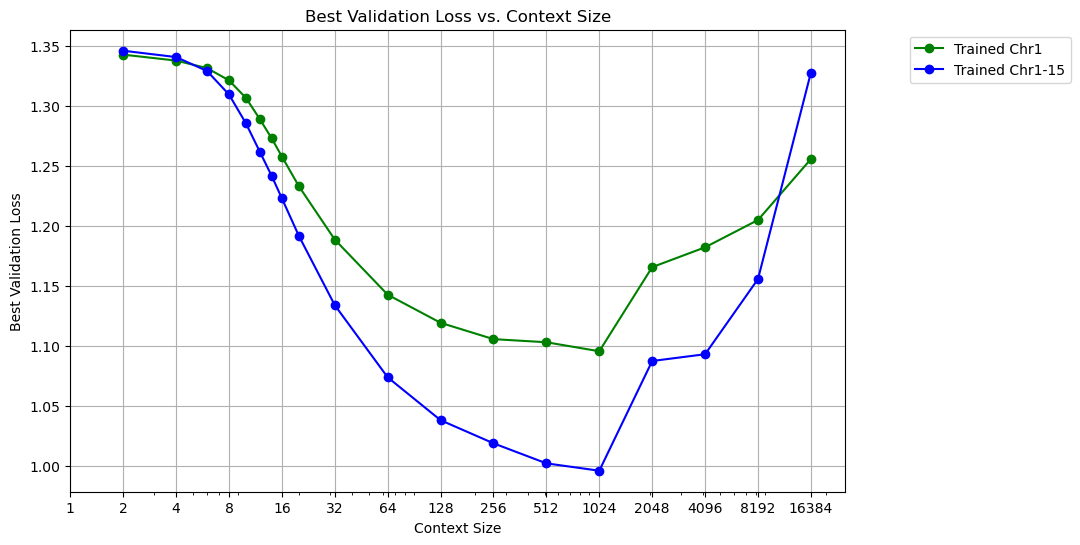

In [7]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_Z1['context_size'], df_Z1['best_val_loss'], marker='o', linestyle='-', color='g', label='Trained Chr1')
plt.plot(df_Z2['context_size'], df_Z2['best_val_loss'], marker='o', linestyle='-', color='b', label='Trained Chr1-15')

# Adding labels and title
plt.xlabel('Context Size')
plt.ylabel('Best Validation Loss')
plt.title('Best Validation Loss vs. Context Size')
plt.grid(True)
plt.xscale('log')
plt.xticks([1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384], labels=[1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384])
#plt.xlim(1, 256)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))  # Move the legend outside the plot

# Optionally set a log scale for context_size if needed
# plt.xscale('log')

plt.show()

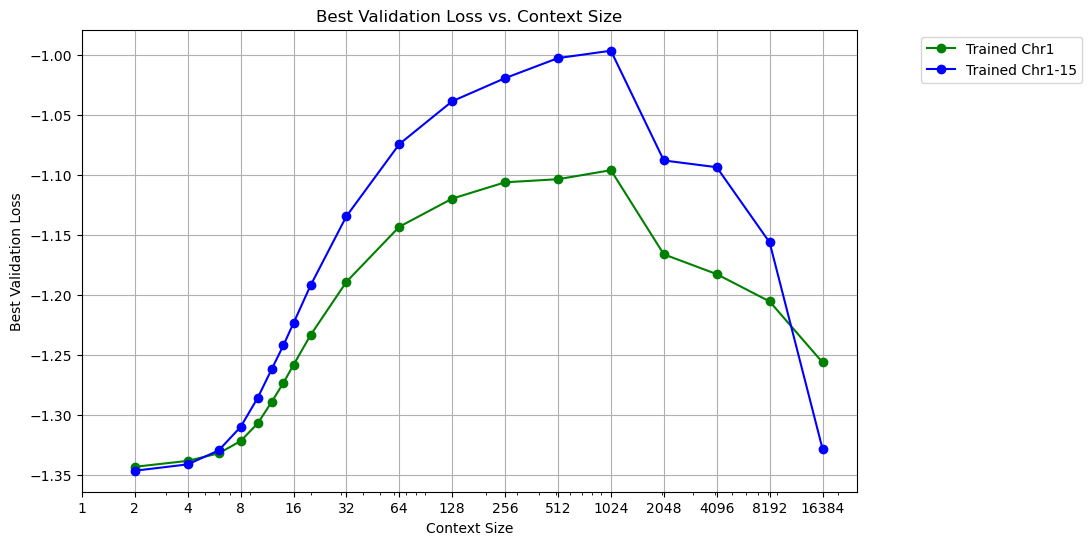

In [8]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_Z1['context_size'], - df_Z1['best_val_loss'], marker='o', linestyle='-', color='g', label='Trained Chr1')
plt.plot(df_Z2['context_size'], - df_Z2['best_val_loss'], marker='o', linestyle='-', color='b', label='Trained Chr1-15')

# Adding labels and title
plt.xlabel('Context Size')
plt.ylabel('Best Validation Loss')
plt.title('Best Validation Loss vs. Context Size')
plt.grid(True)
plt.xscale('log')
plt.xticks([1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384], labels=[1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384])
#plt.xlim(1, 256)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))  # Move the legend outside the plot

# Optionally set a log scale for context_size if needed
# plt.xscale('log')

plt.show()

In [5]:
import os
import re
import pandas as pd

base_out_dir = '../nanoGPT/OUT_GENOMIC_MODELS/out_Architecture_nr_1_A7/'

# Initialize an empty list to store the data
data = []

# Iterate through all subdirectories within the base directory
for subdir in os.listdir(base_out_dir):
    out_dir = os.path.join(base_out_dir, subdir)
    if os.path.isdir(out_dir) and not subdir.startswith('.') and 'A7' in out_dir and os.path.exists(os.path.join(out_dir, 'ckpt.pt')):
        _, _, best_val_loss = model_info(out_dir, verbose=False)
        match = re.search(r'Context_size_(\d+)', subdir)
        if match:
            context_size = match.group(1)
            # Append the context size and best validation loss to the data list
            data.append({'context_size': int(context_size), 'best_val_loss': float(best_val_loss)})
        else:
            print("Context size not found")

# Convert the data list to a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df_A7=df.sort_values(by='context_size')

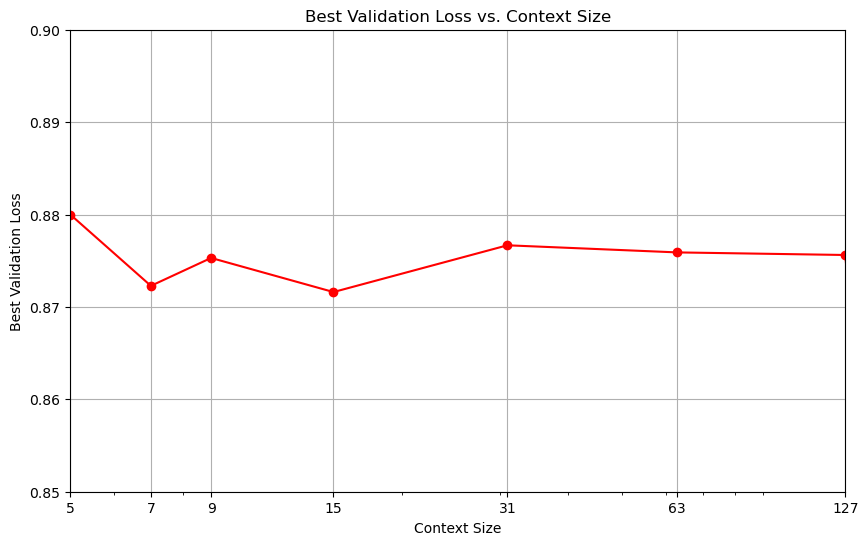

In [9]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_A7['context_size'], df_A7['best_val_loss'], marker='o', linestyle='-', color='r')

# Adding labels and title
plt.xlabel('Context Size')
plt.ylabel('Best Validation Loss')
plt.title('Best Validation Loss vs. Context Size')
plt.grid(True)
plt.xscale('log')
#plt.xticks([3, 5, 7, 9 ,15, 31 ,63 ,127, 255], labels=[3, 5, 7, 9 ,15, 31 ,63 ,127, 255])
plt.xticks([ 5, 7, 9 ,15, 31 ,63 ,127], labels=[5, 7, 9 ,15, 31 ,63 ,127])
plt.xlim(5, 127)
plt.ylim(0.85,0.9)
# Optionally set a log scale for context_size if needed
# plt.xscale('log')

plt.show()